In [1]:
from utils import runwrite
import matplotlib.pyplot as plt

# features.py

In [2]:
%%runwrite ../timegym/features.py

import numpy as np
import pandas as pd

In [3]:
df = pd.DataFrame(np.random.normal(size=1000), columns=['target'], 
                  index=pd.date_range('2012-12-12', periods=1000))
df

,target
2012-12-12,-0.696532
2012-12-13,-2.157287
2012-12-14,-0.608795
2012-12-15,-0.088061
2012-12-16,0.249848
...,...
2015-09-03,-1.031387
2015-09-04,0.259950
2015-09-05,-0.135426
2015-09-06,-1.245667


## Using the target of previous days as features

In [4]:
%%runwrite -a ../timegym/features.py

def add_lagged_target(df, lags=10, dropna=True):
    df = df.copy()
    for col in df.columns:
        for lag in range(1, 1+lags):
            df[f'{col}_t-{lag}'] = df[col].shift(lag)
    if dropna:
        df.dropna(inplace=True)
    return df

In [5]:
add_lagged_target(df)

,target,target_t-1,target_t-2,target_t-3,target_t-4,target_t-5,target_t-6,target_t-7,target_t-8,target_t-9,target_t-10
2012-12-22,-0.404982,0.102805,0.745155,-0.620956,1.030516,0.835538,0.249848,-0.088061,-0.608795,-2.157287,-0.696532
2012-12-23,-1.417407,-0.404982,0.102805,0.745155,-0.620956,1.030516,0.835538,0.249848,-0.088061,-0.608795,-2.157287
2012-12-24,-0.615445,-1.417407,-0.404982,0.102805,0.745155,-0.620956,1.030516,0.835538,0.249848,-0.088061,-0.608795
2012-12-25,0.926000,-0.615445,-1.417407,-0.404982,0.102805,0.745155,-0.620956,1.030516,0.835538,0.249848,-0.088061
2012-12-26,-0.799841,0.926000,-0.615445,-1.417407,-0.404982,0.102805,0.745155,-0.620956,1.030516,0.835538,0.249848
...,...,...,...,...,...,...,...,...,...,...,...
2015-09-03,-1.031387,-0.285229,-0.330652,1.273287,3.119797,0.345723,0.249155,0.319404,-0.157022,-1.373209,-0.022481
2015-09-04,0.259950,-1.031387,-0.285229,-0.330652,1.273287,3.119797,0.345723,0.249155,0.319404,-0.157022,-1.373209
2015-09-05,-0.135426,0.259950,-1.031387,-0.285229,-0.330652,1.273287,3.119797,0.345723,0.249155,0.319404,-0.157022
2015-09-06,-1.245667,-0.135426,0.259950,-1.031387,-0.285229,-0.330652,1.273287,3.119797,0.345723,0.249155,0.319404


## Encoding of cyclical time features

In [6]:
%%runwrite -a ../timegym/features.py

def cyclical_encoding(values, scaled=False, min_value=None, max_value=None):
    if scaled:
        scaled = values
    else:
        min_value = min_value or np.min(values)
        max_value = max_value or np.max(values)
        scaled = (values-min_value)/max_value
    cos = np.cos(scaled*np.pi*2)
    sin = np.sin(scaled*np.pi*2)
    return cos, sin

In [7]:
months = np.arange(1,13)
cos, sin = cyclical_encoding(months)
pd.DataFrame([months, cos, sin], index=['month', 'month_cos', 'month_sin']).T

,month,month_cos,month_sin
0,1.0,1.000000e+00,0.000000e+00
1,2.0,8.660254e-01,5.000000e-01
2,3.0,5.000000e-01,8.660254e-01
3,4.0,6.123234e-17,1.000000e+00
4,5.0,-5.000000e-01,8.660254e-01
5,6.0,-8.660254e-01,5.000000e-01
6,7.0,-1.000000e+00,1.224647e-16
7,8.0,-8.660254e-01,-5.000000e-01
8,9.0,-5.000000e-01,-8.660254e-01
9,10.0,-1.836970e-16,-1.000000e+00


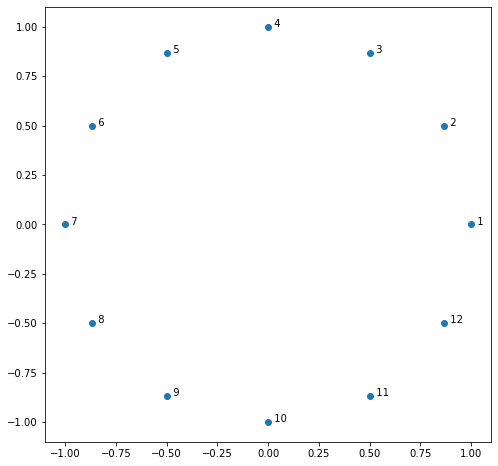

In [8]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(cos, sin)
for m, c, s in zip(months, cos, sin):
    ax.annotate(f'  {m}', (c, s))

clockwork!

## Comprehensive time features

In [9]:
%%runwrite -a ../timegym/features.py

def add_time_features(df):
    df = df.copy()
    df['time'] = df.index.astype(int)
    df['time'] = df['time'] / df['time'].std()
    if df.index.year.nunique()>1: df['year'] = df.index.year
    # cyclical encoding using trigonometric functions (sin, cos)
    cyclical_time_features = True
    if cyclical_time_features:    
        if df.index.quarter.nunique()>1: 
            cos, sin = cyclical_encoding(df.index.quarter, min_value=1, max_value=4)
            df['quarter_cos'], df['quarter_sin'] = cos, sin
        if df.index.month.nunique()>1: 
            cos, sin = cyclical_encoding(df.index.month, min_value=1, max_value=12)
            df['month_cos'], df['month_sin'] = cos, sin
        unadjusted_days = True
        if unadjusted_days and df.index.day.nunique()>1:
            cos, sin = cyclical_encoding(df.index.day, min_value=1, max_value=31)
            df['day_cos'], df['day_sin'] = cos, sin
        adjusted_days = True
        if adjusted_days and df.index.day.nunique()>1:
            adjusted_days = (df.index.day - 1) / df.index.daysinmonth
            cos, sin = cyclical_encoding(adjusted_days, scaled=True)
            df['day_adj_cos'], df['day_adj_sin'] = cos, sin
        if df.index.weekday.nunique()>1: 
            cos, sin = cyclical_encoding(df.index.weekday, min_value=0, max_value=6)
            df['weekday_cos'], df['weekday_sin'] = cos, sin
        if df.index.hour.nunique()>1:
            cos, sin = cyclical_encoding(df.index.hour, min_value=0, max_value=23)
            df['hour_cos'], df['hour_sin'] = cos, sin
        if df.index.minute.nunique()>1:
            cos, sin = cyclical_encoding(df.index.minute, min_value=0, max_value=59)
            df['minute_cos'], df['minute_sin'] = cos, sin
        if df.index.second.nunique()>1:
            cos, sin = cyclical_encoding(df.index.second, min_value=0, max_value=59)
            df['second_cos'], df['second_sin'] = cos, sin
        if df.index.microsecond.nunique()>1:
            cos, sin = cyclical_encoding(df.index.miliosecond, min_value=0, max_value=999999)
            df['microsecond_cos'], df['microsecond_sin'] = cos, sin
    # no encoding
    else:
        if df.index.quarter.nunique()>1: df['quarter'] = df.index.quarter
        if df.index.month.nunique()>1: df['month'] = df.index.month
        if df.index.day.nunique()>1: df['day'] = df.index.day
        if df.index.weekday.nunique()>1: df['weekday'] = df.index.weekday
        if df.index.hour.nunique()>1: df['hour'] = df.index.hour
        if df.index.minute.nunique()>1: df['minute'] = df.index.minute
        if df.index.second.nunique()>1: df['second'] = df.index.second
        if df.index.microsecond.nunique()>1: df['microsecond'] = df.index.microsecond
    return df

In [10]:
add_time_features(df)

,target,time,year,quarter_cos,quarter_sin,month_cos,month_sin,day_cos,day_sin,day_adj_cos,day_adj_sin,weekday_cos,weekday_sin
2012-12-12,-0.696532,54.310749,2012,-1.836970e-16,-1.000000e+00,0.866025,-0.500000,-0.612106,0.790776,-0.612106,0.790776,-0.5,8.660254e-01
2012-12-13,-2.157287,54.314212,2012,-1.836970e-16,-1.000000e+00,0.866025,-0.500000,-0.758758,0.651372,-0.758758,0.651372,-1.0,1.224647e-16
2012-12-14,-0.608795,54.317674,2012,-1.836970e-16,-1.000000e+00,0.866025,-0.500000,-0.874347,0.485302,-0.874347,0.485302,-0.5,-8.660254e-01
2012-12-15,-0.088061,54.321136,2012,-1.836970e-16,-1.000000e+00,0.866025,-0.500000,-0.954139,0.299363,-0.954139,0.299363,0.5,-8.660254e-01
2012-12-16,0.249848,54.324599,2012,-1.836970e-16,-1.000000e+00,0.866025,-0.500000,-0.994869,0.101168,-0.994869,0.101168,1.0,-2.449294e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-09-03,-1.031387,57.755808,2015,-1.000000e+00,1.224647e-16,-0.500000,-0.866025,0.918958,0.394356,0.913545,0.406737,-1.0,1.224647e-16
2015-09-04,0.259950,57.759271,2015,-1.000000e+00,1.224647e-16,-0.500000,-0.866025,0.820763,0.571268,0.809017,0.587785,-0.5,-8.660254e-01
2015-09-05,-0.135426,57.762733,2015,-1.000000e+00,1.224647e-16,-0.500000,-0.866025,0.688967,0.724793,0.669131,0.743145,0.5,-8.660254e-01
2015-09-06,-1.245667,57.766195,2015,-1.000000e+00,1.224647e-16,-0.500000,-0.866025,0.528964,0.848644,0.500000,0.866025,1.0,-2.449294e-16


## fraunhoferportugal/tsfel

https://github.com/fraunhoferportugal/tsfel

In [11]:
%%runwrite -a ../timegym/features.py

import tsfel
from tqdm import tqdm

def add_tsfel_features(df, use_cols=None, window_size=100, domain=None, frequency=100, dropna=True, show_progress=False, lag=1):
    if use_cols is None:
        data = df
    else: 
        data = df[use_cols]

    cfg = tsfel.get_features_by_domain(domain=domain)
    
    features = []
    iterator = range(window_size, df.shape[0]-lag)
    if show_progress: iterator = tqdm(iterator)
    for window_end in iterator:
        window_start = window_end - window_size
        window = data.iloc[window_start:window_end]
        features.append(tsfel.time_series_features_extractor(cfg, window, verbose=0, fs=frequency))
    features = pd.concat(features, ignore_index=True)
    features.index = df.index[window_size+lag:]
        
    df = pd.concat([data, features], axis=1)
    if dropna:
        df.dropna(inplace=True)
    return df

In [12]:
add_tsfel_features(df)

,target,0_Absolute energy,0_Area under the curve,0_Autocorrelation,0_Centroid,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,...,0_Wavelet variance_0,0_Wavelet variance_1,0_Wavelet variance_2,0_Wavelet variance_3,0_Wavelet variance_4,0_Wavelet variance_5,0_Wavelet variance_6,0_Wavelet variance_7,0_Wavelet variance_8,0_Zero crossing rate
2013-03-23,-0.522364,86.721526,0.488239,86.721526,0.486517,20.0,80.0,-0.883140,0.702792,0.01,...,0.891369,0.990559,0.974299,0.746466,0.574432,0.458429,0.359968,0.274287,0.206411,49.0
2013-03-24,0.706717,90.203991,0.481898,90.203991,0.501719,20.0,80.0,-0.914013,0.702792,0.01,...,0.897684,0.954843,0.937472,0.736493,0.571064,0.457556,0.374510,0.309227,0.259809,50.0
2013-03-25,0.548998,85.822968,0.480639,85.822968,0.520510,20.0,80.0,-0.883140,0.702792,0.01,...,0.887413,0.868385,0.864261,0.735450,0.593848,0.469657,0.381877,0.329116,0.301821,50.0
2013-03-26,1.123529,85.951785,0.478077,85.951785,0.515541,20.0,80.0,-0.883140,0.706717,0.01,...,0.897372,0.850883,0.859798,0.740946,0.598008,0.468806,0.375588,0.320275,0.293420,51.0
2013-03-27,0.959729,86.245429,0.483546,86.245429,0.507280,20.0,80.0,-0.883140,0.706717,0.01,...,0.913729,0.863159,0.866829,0.738962,0.590759,0.461612,0.367332,0.309030,0.278968,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-09-03,-1.031387,87.403581,0.485794,87.403581,0.547995,20.0,80.0,-0.686091,0.647405,0.01,...,0.858869,0.737428,0.857343,0.864952,0.704751,0.567295,0.522253,0.552747,0.625712,53.0
2015-09-04,0.259950,86.577236,0.481998,86.577236,0.544165,20.0,80.0,-0.686091,0.577381,0.01,...,0.873229,0.724153,0.825587,0.846482,0.704153,0.579675,0.542317,0.573541,0.641646,53.0
2015-09-05,-0.135426,87.462559,0.487158,87.462559,0.540819,20.0,80.0,-0.723593,0.577381,0.01,...,0.869778,0.790558,0.844573,0.833761,0.688849,0.573464,0.542088,0.568548,0.622520,52.0
2015-09-06,-1.245667,87.511133,0.488621,87.511133,0.531291,20.0,80.0,-0.723593,0.577381,0.01,...,0.873871,0.804348,0.854150,0.833193,0.685945,0.568960,0.536303,0.564089,0.622413,53.0


## Cyclical features

## blue-yonder/tsfresh

https://github.com/blue-yonder/tsfresh

In [ ]:
# TODO

## sktime feature engineering?

In [ ]:
# TODO

## pytime

In [ ]:
# TODO

## libraries from R

https://cran.r-project.org/web/packages/tsfeatures/index.html

VEST: https://arxiv.org/pdf/2010.07137.pdf

## technical analysis

https://github.com/bukosabino/ta

https://github.com/twopirllc/pandas-ta

In [ ]:
# time feature: exponential time